In [6]:
'''
CSC 396 - Intro to Deep Learning w/ NLP Apps
Final Project - Harmful Content Classifier
December 9, 2025
Claire Lynch & Jose Santiago Campa Morales
'''

import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 1234


In [7]:
# Load Hate Speech Dataset
file_path = "data/labeled_data.csv"
df = pd.read_csv(file_path)

# CSV columns: class, tweet
df = df[['class', 'tweet']].copy()

# Map class integers to descriptive labels
label_map = {
    0: "hate_speech",
    1: "offensive_language",
    2: "neither"
}

df['label_str'] = df['class'].map(label_map)

print("random examples from each class:\n")
for label in ["hate_speech", "offensive_language", "neither"]:
    print(f"Label: {label}")
    examples = df[df['label_str'] == label][['label_str', 'tweet']].sample(10, random_state=seed)
    print(examples.to_string(index=False))
    print("-" * 60)


random examples from each class:

Label: hate_speech
  label_str                                                                                 tweet
hate_speech                                         RT @natal_mendoz: Whore slut cunt bitch nigga
hate_speech    @young_moniee what's this chinks email? I'm moving to China and slicing his throat
hate_speech @Buckm00se true sand niggers &amp; bum Brits claim he's a ATG hall of fame legend smh
hate_speech                        @Alicia112794 So basically you like the background music, fag.
hate_speech                                          It's a lot of Uncle Tom ass niggas out here.
hate_speech     @TheKushZombie Aww y u so mad tho, a successful man LMFAO, hut hugging as faggot.
hate_speech                          @truuueee_ that bitch done.. have it to u on Sunday my nigga
hate_speech                     White trash have taken over every charity organization in the US.
hate_speech                                        @JaiBrooks1 ur

In [8]:
# Samples
print("\nSample tweets:")
print(df.sample(10))


Sample tweets:
       class                                              tweet  \
9236       1  Fuck all y'all hoes &#128567; gang shit &#1281...   
1022       1  &#128530;RT @SedSince81: niggers RT @VonshayeB...   
2785       2  @Carxlito PS3 and case is still in the trash c...   
20895      1                 Smellin good, bitches wanna hug me   
12505      1                                   Lmao this bitch.   
2301       2  @0xabad1dea Hard to QA? Time is also a pain to...   
608        1  "You can take someone out of the ghetto, but y...   
15019      1  RT @DomBeets: I wish someone would make a song...   
16696      1  RT @NorrisDaGod: I ain't never had a basic bit...   
1209       2  &#8220;@DShmee: Tom Brady slowly becoming wash...   

                label_str  
9236   offensive_language  
1022   offensive_language  
2785              neither  
20895  offensive_language  
12505  offensive_language  
2301              neither  
608    offensive_language  
15019  offensive_langu

In [9]:
# Basic Stats
print("\nLabel distribution:")
print(df['label_str'].value_counts())


Label distribution:
label_str
offensive_language    19190
neither                4163
hate_speech            1430
Name: count, dtype: int64


C:\Users\jscm1\AppData\Local\Temp\ipykernel_29152\1137199208.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['label_str']).plot.bar()


<Axes: xlabel='label_str'>

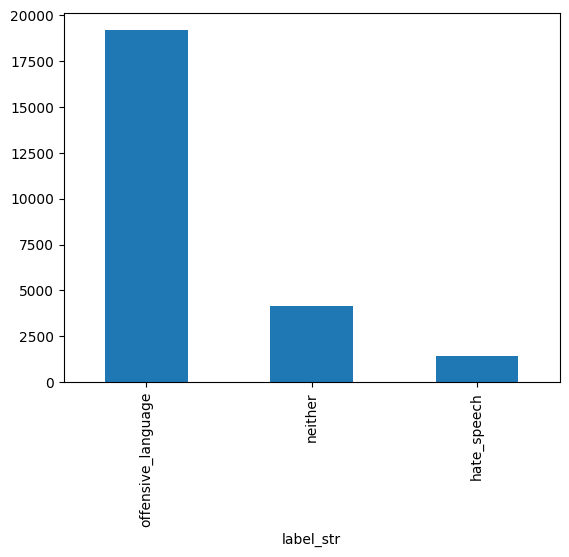

In [10]:
pd.value_counts(df['label_str']).plot.bar()

In [11]:
# Train / Validation Split
from sklearn.model_selection import train_test_split

# 80/20 split
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['class'])
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

print(f"Train rows: {len(train_df):,}")
print(f"Eval rows: {len(eval_df):,}")

Train rows: 19,826
Eval rows: 4,957


In [12]:
# Convert to HuggingFace Dataset
from datasets import Dataset, DatasetDict

ds = DatasetDict()
ds['train'] = Dataset.from_pandas(train_df)
ds['validation'] = Dataset.from_pandas(eval_df)

In [13]:
# Tokenization
from transformers import AutoTokenizer

# BERT
transformer_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(transformer_name)

In [14]:
def tokenize(examples):
    return tokenizer(examples['tweet'], truncation=True, padding="max_length", max_length=128)

# Tokenize but keep 'class' column
train_ds = ds['train'].map(
    tokenize,
    batched=True,
    remove_columns=['tweet']
)

eval_ds = ds['validation'].map(
    tokenize,
    batched=True,
    remove_columns=['tweet']
)

# Rename 'class' to 'labels' so Trainer knows it
train_ds = train_ds.rename_column("class", "labels")
eval_ds = eval_ds.rename_column("class", "labels")

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [15]:
from torch import nn
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput

class BertForSequenceClassification(BertPreTrainedModel):
    # constructor
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Keyword Arguments from BERT
        bert_kwargs = {k: v for k, v in kwargs.items() if k in [
            "position_ids", "head_mask", "inputs_embeds", 
            "output_attentions", "output_hidden_states", "return_dict"
        ]}
        
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **bert_kwargs,
        )

        # Vector for the sentence
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        # Loss
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [16]:
# Config
from transformers import AutoConfig
config = AutoConfig.from_pretrained(transformer_name, num_labels=3)

In [17]:
# Model
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    transformer_name,
    num_labels=len(label_map)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Training Arguments
from transformers import TrainingArguments

num_epochs = 3
batch_size = 16
weight_decay = 0.01
model_name = f"{transformer_name}-hate-speech"

training_args = TrainingArguments(
    output_dir=model_name,
    log_level='info',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_strategy='epoch',
    save_strategy='epoch',
    weight_decay=weight_decay,
    logging_dir=f"{model_name}/logs",

    logging_steps=10,
    disable_tqdm=False,

    report_to=None,
)

In [19]:
# Metrics
from sklearn.metrics import accuracy_score, classification_report

def compute_metrics(eval_pred):
    y_true = eval_pred.label_ids
    y_pred = np.argmax(eval_pred.predictions, axis=-1)
    return {'accuracy': accuracy_score(y_true, y_pred)}

In [20]:
# Trainer
from transformers import Trainer

# HuggingFace to train
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer
)

C:\Users\jscm1\AppData\Local\Temp\ipykernel_29152\295363021.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
# Train Model
trainer.train()

The following columns in the Training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_str. If label_str are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 19,826
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3,720
  Number of trainable parameters = 109,484,547


Epoch,Training Loss,Validation Loss,Accuracy
1,0.252000,0.266959,0.910631
2,0.145900,0.260103,0.916885
3,0.130600,0.294343,0.918903


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_str. If label_str are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 4957
  Batch size = 16
Saving model checkpoint to bert-base-uncased-hate-speech\checkpoint-1240
Configuration saved in bert-base-uncased-hate-speech\checkpoint-1240\config.json
Model weights saved in bert-base-uncased-hate-speech\checkpoint-1240\model.safetensors
tokenizer config file saved in bert-base-uncased-hate-speech\checkpoint-1240\tokenizer_config.json
Special tokens file saved in bert-base-uncased-hate-speech\checkpoint-1240\special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_str. If label_str are not expected by `BertForSequenceClassification.

TrainOutput(global_step=3720, training_loss=0.23496588894756892, metrics={'train_runtime': 1227.1066, 'train_samples_per_second': 48.47, 'train_steps_per_second': 3.032, 'total_flos': 3912364964906496.0, 'train_loss': 0.23496588894756892, 'epoch': 3.0})

In [22]:
# Predictions
output = trainer.predict(eval_ds)
y_true = output.label_ids
y_pred = np.argmax(output.predictions, axis=-1)

print(classification_report(y_true, y_pred, target_names=list(label_map.values())))

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_str. If label_str are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 4957
  Batch size = 16


                    precision    recall  f1-score   support

       hate_speech       0.58      0.35      0.44       286
offensive_language       0.94      0.96      0.95      3838
           neither       0.89      0.90      0.90       833

          accuracy                           0.92      4957
         macro avg       0.80      0.74      0.76      4957
      weighted avg       0.91      0.92      0.91      4957



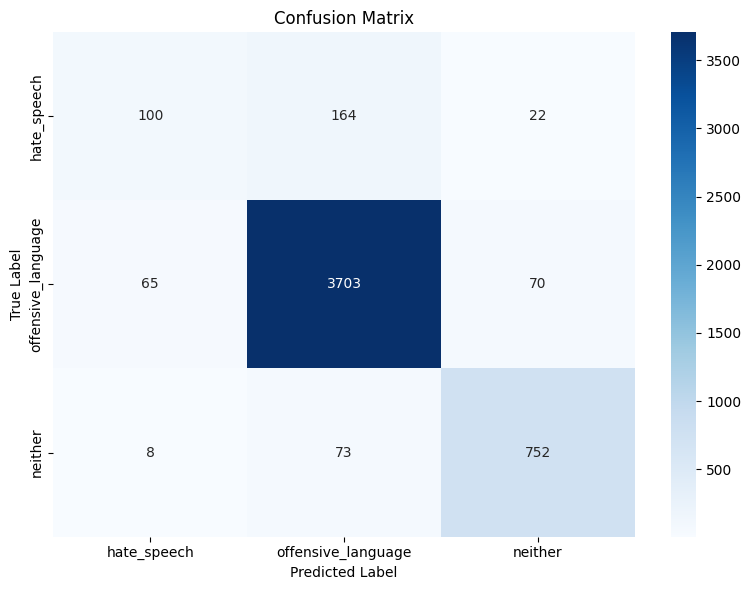

In [23]:
# Error Analysis
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(label_map.values())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [24]:
# False Positives and False Negatives
import pandas as pd

# Create predictions DataFrame for analysis
eval_df_with_pred = eval_df.copy()
eval_df_with_pred['predicted'] = y_pred
eval_df_with_pred['predicted_label'] = eval_df_with_pred['predicted'].map(label_map)
eval_df_with_pred['correct'] = eval_df_with_pred['class'] == eval_df_with_pred['predicted']

print("HATE SPEECH ANALYSIS")

# Hate Speech False Negatives (missed hate speech)
hate_fn = eval_df_with_pred[(eval_df_with_pred['class'] == 0) & (eval_df_with_pred['predicted'] != 0)]
print(f"\nHate Speech False Negatives: {len(hate_fn)} cases")
print("Sample missed hate speech:")
if len(hate_fn) > 0:
    print(hate_fn[['tweet', 'predicted_label']].head(3).to_string(index=False))

# Hate Speech False Positives (wrongly predicted as hate speech)
hate_fp = eval_df_with_pred[(eval_df_with_pred['class'] != 0) & (eval_df_with_pred['predicted'] == 0)]
print(f"\nHate Speech False Positives: {len(hate_fp)} cases")
print("Sample wrongly classified as hate speech:")
if len(hate_fp) > 0:
    print(hate_fp[['tweet', 'label_str']].head(3).to_string(index=False))

HATE SPEECH ANALYSIS

Hate Speech False Negatives: 186 cases
Sample missed hate speech:
                                                                                                            tweet    predicted_label
@karmendanielle_ u gotta slow down these coon hrs all they know is love n hip hop, lebron, &amp; fake love quotes offensive_language
                                                                     Lemme find out that bitch nigga talking shit offensive_language
                                   Eagles fuck around &amp; lose it'll be kill the cracker at the Sophi crib smfh offensive_language

Hate Speech False Positives: 73 cases
Sample wrongly classified as hate speech:
                                                                                                                                       tweet          label_str
                                                @MANIAC3X buck beaners &amp; security started pushing him &amp; that jetsgreen faggot aroun

## Alternative Approach: Binary Classification

Binary classification distribution:
binary_label
harmful        20620
not harmful     4163
Name: count, dtype: int64
Balance: binary_label
harmful        0.832022
not harmful    0.167978
Name: proportion, dtype: float64


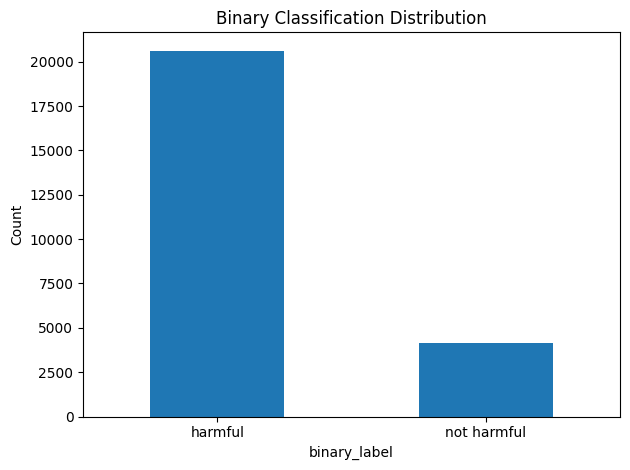

In [25]:
# Binary Classification: Harmful Content vs Not Harmful

# Binary dataset
binary_df = df.copy()
# originally 0,1 are harmful, 2 is neither
binary_df['binary_class'] = (binary_df['class'] != 2).astype(int)  # 0=neither, 1=harmful
binary_df['binary_label'] = binary_df['binary_class'].map({0: 'not harmful', 1: 'harmful'})

print("Binary classification distribution:")
print(binary_df['binary_label'].value_counts())
print(f"Balance: {binary_df['binary_label'].value_counts(normalize=True)}")

# Binary distribution
binary_df['binary_label'].value_counts().plot.bar(title='Binary Classification Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
# Create binary train/test splits
binary_train_df, binary_eval_df = train_test_split(
    binary_df, 
    test_size=0.2, 
    random_state=seed, 
    stratify=binary_df['binary_class']
)
binary_train_df.reset_index(drop=True, inplace=True)
binary_eval_df.reset_index(drop=True, inplace=True)

print(f"Binary Train rows: {len(binary_train_df):,}")
print(f"Binary Eval rows: {len(binary_eval_df):,}")
print(f"\nBinary Train distribution:")
print(binary_train_df['binary_label'].value_counts())
print(f"\nBinary Eval distribution:")
print(binary_eval_df['binary_label'].value_counts())

Binary Train rows: 19,826
Binary Eval rows: 4,957

Binary Train distribution:
binary_label
harmful        16496
not harmful     3330
Name: count, dtype: int64

Binary Eval distribution:
binary_label
harmful        4124
not harmful     833
Name: count, dtype: int64


In [27]:
# Convert binary data to HuggingFace Dataset
binary_ds = DatasetDict()
binary_ds['train'] = Dataset.from_pandas(binary_train_df)
binary_ds['validation'] = Dataset.from_pandas(binary_eval_df)

# Tokenize binary datasets
binary_train_ds = binary_ds['train'].map(
    tokenize,
    batched=True,
    remove_columns=['tweet']
)

binary_eval_ds = binary_ds['validation'].map(
    tokenize,
    batched=True,
    remove_columns=['tweet']
)

# Rename binary_class to labels for Trainer
binary_train_ds = binary_train_ds.rename_column("binary_class", "labels")
binary_eval_ds = binary_eval_ds.rename_column("binary_class", "labels")

print(f"Binary train dataset size: {len(binary_train_ds)}")
print(f"Binary eval dataset size: {len(binary_eval_ds)}")

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Binary train dataset size: 19826
Binary eval dataset size: 4957


In [28]:
# Binary Model Setup
binary_model = BertForSequenceClassification.from_pretrained(
    transformer_name,
    num_labels=2  # Binary classification
)

# Binary Training Arguments
binary_model_name = f"{transformer_name}-binary-harmful-content"

binary_training_args = TrainingArguments(
    output_dir=binary_model_name,
    log_level='info',
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_strategy='epoch',
    save_strategy='epoch',
    weight_decay=weight_decay,
    logging_dir=f"{binary_model_name}/logs",
    logging_steps=10,
    disable_tqdm=False,

    report_to=None,

    save_total_limit=2,
)

loading configuration file config.json from cache at C:\Users\jscm1\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\jscm1\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\model.safetensors
Some weights 

In [29]:
# Binary Trainer
binary_trainer = Trainer(
    model=binary_model,
    args=binary_training_args,
    compute_metrics=compute_metrics,
    train_dataset=binary_train_ds,
    eval_dataset=binary_eval_ds,
    tokenizer=tokenizer
)

C:\Users\jscm1\AppData\Local\Temp\ipykernel_29152\3067831500.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  binary_trainer = Trainer(


In [30]:
# Train Binary Model
binary_trainer.train()

The following columns in the Training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: binary_label, class, label_str. If binary_label, class, label_str are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 19,826
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3,720
  Number of trainable parameters = 109,483,778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.087300,0.093320,0.965705
2,0.055500,0.119094,0.968328
3,0.044200,0.155414,0.964495


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: binary_label, class, label_str. If binary_label, class, label_str are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 4957
  Batch size = 16
Saving model checkpoint to bert-base-uncased-binary-harmful-content\checkpoint-1240
Configuration saved in bert-base-uncased-binary-harmful-content\checkpoint-1240\config.json
Model weights saved in bert-base-uncased-binary-harmful-content\checkpoint-1240\model.safetensors
tokenizer config file saved in bert-base-uncased-binary-harmful-content\checkpoint-1240\tokenizer_config.json
Special tokens file saved in bert-base-uncased-binary-harmful-content\checkpoint-1240\special_tokens_map.json
Deleting older checkpoint [bert-base-uncased-binary-harmful-content\checkpoint-2480] due to args.save_total_limit
The follow

TrainOutput(global_step=3720, training_loss=0.09154252287986818, metrics={'train_runtime': 1244.4908, 'train_samples_per_second': 47.793, 'train_steps_per_second': 2.989, 'total_flos': 3912329837675520.0, 'train_loss': 0.09154252287986818, 'epoch': 3.0})

In [31]:
# Evaluate Binary Model
binary_output = binary_trainer.predict(binary_eval_ds)
binary_y_true = binary_output.label_ids
binary_y_pred = np.argmax(binary_output.predictions, axis=-1)

# Binary class labels
binary_labels = ['not harmful', 'harmful']

print("BINARY CLASSIFICATION RESULTS")
print(classification_report(binary_y_true, binary_y_pred, target_names=binary_labels))

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: binary_label, class, label_str. If binary_label, class, label_str are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 4957
  Batch size = 16


BINARY CLASSIFICATION RESULTS
              precision    recall  f1-score   support

 not harmful       0.90      0.88      0.89       833
     harmful       0.98      0.98      0.98      4124

    accuracy                           0.96      4957
   macro avg       0.94      0.93      0.94      4957
weighted avg       0.96      0.96      0.96      4957



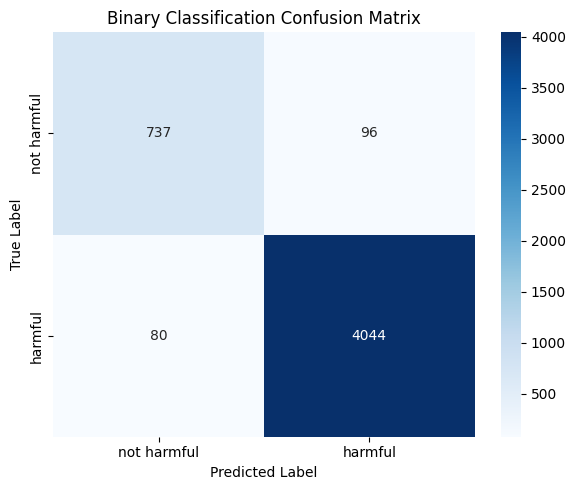


BINARY ERROR ANALYSIS

False Negatives (missed harmful content): 80 cases
Sample missed harmful content:
                                                                                                                                                                            tweet          label_str
                                                                                                                                                 ur trash! http://t.co/6KN7PzTgl8 offensive_language
                                                                    Fight me RT @rob_b1991: 0 cuz they're trash RT @Markie__Marc: How many 50-cent corn dogs did you order today? offensive_language
                                  @DonnerKay @surlyrevenant An enraged 6'4" 290 lb Mike Brown lethal weapon on legs.His hatred 4 the police &amp; whitey added fuel 2 his arsenal        hate_speech
                                                                                               @freshalina

In [32]:
# Binary Confusion Matrix and Error Analysis
binary_cm = confusion_matrix(binary_y_true, binary_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=binary_labels, yticklabels=binary_labels)
plt.title('Binary Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Binary error analysis
binary_eval_df_with_pred = binary_eval_df.copy()
binary_eval_df_with_pred['predicted'] = binary_y_pred
binary_eval_df_with_pred['predicted_label'] = binary_eval_df_with_pred['predicted'].map({0: 'neither', 1: 'harmful'})
binary_eval_df_with_pred['correct'] = binary_eval_df_with_pred['binary_class'] == binary_eval_df_with_pred['predicted']

print("\nBINARY ERROR ANALYSIS")

# False Negatives (missed harmful content)
binary_fn = binary_eval_df_with_pred[(binary_eval_df_with_pred['binary_class'] == 1) & (binary_eval_df_with_pred['predicted'] == 0)]
print(f"\nFalse Negatives (missed harmful content): {len(binary_fn)} cases")
if len(binary_fn) > 0:
    print("Sample missed harmful content:")
    print(binary_fn[['tweet', 'label_str']].to_string(index=False))

# False Positives (wrongly flagged as harmful)
binary_fp = binary_eval_df_with_pred[(binary_eval_df_with_pred['binary_class'] == 0) & (binary_eval_df_with_pred['predicted'] == 1)]
print(f"\nFalse Positives (wrongly flagged as harmful): {len(binary_fp)} cases")
if len(binary_fp) > 0:
    print("Sample wrongly flagged content:")
    print(binary_fp[['tweet', 'label_str']].to_string(index=False))